In [1]:
from dem.energies.tblite_energy import TBLiteEnergy
import numpy as np
import pickle
import torch 
from dem.energies.base_energy_function import BaseEnergyFunction
from dem.energies.lennardjones_energy import LennardJonesEnergy 
from dem.models.components.clipper import Clipper
from dem.models.components.noise_schedules import BaseNoiseSchedule, GeometricNoiseSchedule
from dem.models.components.score_estimator import get_logreward_noised_samples

#  Make dataset for cyclic peptides idem

In [2]:
import numpy as np

data = np.load('data/test_split_LJ13-1000.npy')
data.shape

(10000, 39)

In [3]:
from Bio import PDB
import numpy as np
import periodictable

def get_atomicnumber(max_Z = 50):
    '''Maps the atomic number to the atom elements in the periodic table.'''
    atom2atomicnumber = {}
    atomicnumber2atom = {}
    for atomicnumber in range(max_Z):
        element = periodictable.elements[atomicnumber + 1] 
        atom2atomicnumber[element.symbol] = atomicnumber + 1
        atomicnumber2atom[atomicnumber + 1] = element.symbol
    return atom2atomicnumber, atomicnumber2atom


def extract_column_from_pdb(pdb_path, start, end):
    column_data = []
    with open(pdb_path, 'r') as pdb_file:
        for line in pdb_file:
            if line.startswith('ENDMDL'):
                break
            if line.startswith('ATOM'):
                column_value = line[start:end].strip() 
                column_data.append(column_value)
    return column_data

def get_coord(model):
    '''Extracts the coordinates of the atoms in the model.'''
    coords = []
    for chain in model:
        for residue in chain:
            for atom in residue:
                x,y,z = atom.get_coord()
                coords.append([x,y,z])
    return np.array(coords).flatten()


def get_models_atoms(pdb_path ):
    '''Extracts the models and atom ids from the pdb file.'''
    atom2atomicnumber, _ = get_atomicnumber()
    parser = PDB.PDBParser()
    io = PDB.PDBIO()
    struct = parser.get_structure('structure_id',f'{pdb_path}')
    atom_names = []
    models = list(struct.get_models())
    atom_names = extract_column_from_pdb(f'{pdb_path}', 77, 78)
    atom_ids = np.array([atom2atomicnumber[x] for x in atom_names ])
    return models, atom_ids

def get_coords(pdb_path):
    models, atom_ids = get_models_atoms(pdb_path)
    coords = []
    for model in models:
        coords.append(get_coord(model))
    return np.array(coords)


In [5]:
pdb_path = '/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/T.I.f.V.pdb'
coords = get_coords(pdb_path)
coords.shape

(283, 207)

In [6]:
coords_train, coords_val = np.array([]), coords
np.save('/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_train.npy', coords_train)
np.save('/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_val.npy', coords_val)


# TorchANI on a cyclic peptide

In [21]:
import numpy as np
import pickle
import torch
from dem.energies.torchani_energy import *
from dem.energies.tblite_energy import *


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
coords = torch.tensor(np.load('/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_val.npy'), dtype=torch.float32).to(device).view(-1,69,3).requires_grad_(True)
atom_ids = torch.Tensor(pickle.load(open('/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/atom_ids.pkl', 'rb'))).to(device).long().unsqueeze(0)
#energy_function = TorchaniEnergy(dimensionality = 3*69, n_particles = 69, is_molecule=True, data_path ='/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_val.npy',   data_path_train='/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_train.npy', data_path_val='/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_val.npy', T=0.1, device= device)
energy_function = TBLiteEnergy(dimensionality = 3*69, n_particles = 69, is_molecule=True, data_path ='/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_val.npy',   data_path_train='/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_train.npy', data_path_val='/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_val.npy', T=0.1, device= device)

Let's compare the torchANI-energy distribution for conformations optimized using GFN2xtb, vs random conformations. If they are the same, torchANI is not a good proxy for GFN2xtb.

In [22]:
test_data_logrews =   energy_function(coords[:2])


------------------------------------------------------------
  cycle        total energy    energy error   density error
------------------------------------------------------------
      1      74881.69138392   7.4876474E+04   2.4461832E+00
      2      69821.26056738  -5.0604308E+03   3.9617178E+00
      3      65525.62329818  -4.2956373E+03   3.3276322E+00
      4      65834.49650837   3.0887321E+02   3.3186233E+00
      5      65356.07109282  -4.7842542E+02   3.1360151E+00
      6      64201.94405170  -1.1541270E+03   2.9175091E+00
      7      63848.80483504  -3.5313922E+02   2.6958766E+00
      8      64932.11872369   1.0833139E+03   2.8310047E+00
      9      62945.76829730  -1.9863504E+03   2.3232591E+00
     10      62863.72213727  -8.2046160E+01   2.4327452E+00
     11      62519.59364336  -3.4412849E+02   2.0074188E+00
     12      62071.09334504  -4.4850030E+02   2.0437791E+00
     13      61775.94222962  -2.9515112E+02   1.9443491E+00
     14      61832.92409558   5.698186

In [9]:
test_data_logrews =   energy_function(coords)
rand_coords = 3*torch.randn_like(coords)
random_data_logrews =   energy_function(rand_coords)

------------------------------------------------------------
  cycle        total energy    energy error   density error
------------------------------------------------------------
      1     -101.2379595160  -1.0254221E+02   1.6242103E-01
      2     -101.8354361927  -5.9747668E-01   6.4933516E-02
      3     -101.8713076978  -3.5871505E-02   3.7344083E-02
      4     -101.8826051226  -1.1297425E-02   1.0278015E-02
      5     -101.8844306159  -1.8254933E-03   4.4548929E-03
------------------------------------------------------------

 total:                                   1.848 sec
logrew 1018.8443061590058
------------------------------------------------------------
  cycle        total energy    energy error   density error
------------------------------------------------------------
      1     -101.2374035518  -1.0254175E+02   1.6240706E-01
      2     -101.8352837297  -5.9788018E-01   6.4946729E-02
      3     -101.8712113826  -3.5927653E-02   3.7351489E-02
      4     -101

tensor(18.8443) tensor(18.6589) tensor(-64.4197) tensor(-1001000.)


/tmp/ipykernel_1061932/1826418476.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x for x in dict_data.keys() ])


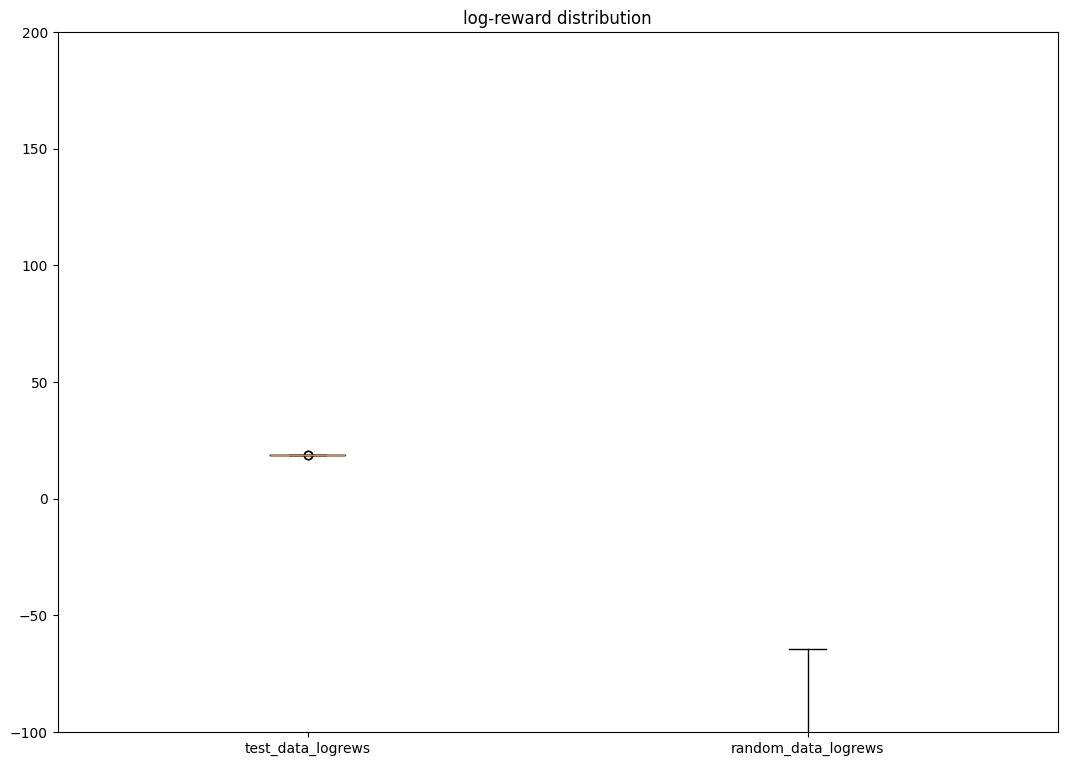

In [33]:
import matplotlib.pyplot as plt

dict_data = {'test_data_logrews': test_data_logrews.detach().cpu() - 1e3 , 'random_data_logrews':  random_data_logrews.detach().cpu() - 1e3}
data = [x for x in dict_data.values()]
print(data[0].max(), data[0].min(), data[1].max(), data[1].min())
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels([x for x in dict_data.keys() ])
ax.set_title('log-reward distribution')
# Creating plot
bp = ax.boxplot(data)
ax.set_ylim([-100, 200])

# show plot
plt.show()

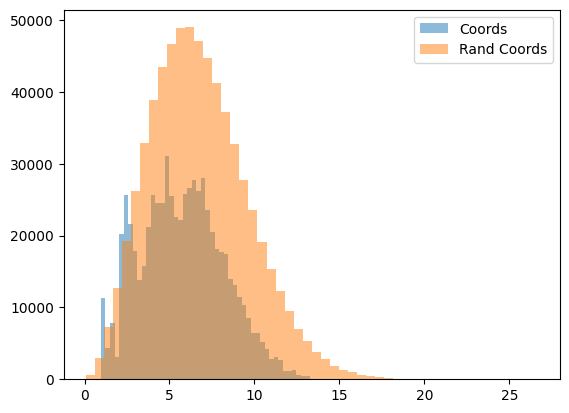

In [34]:
plt.hist(energy_function.interatomic_dist(coords).flatten().detach().cpu(),bins = 50, label='Coords', alpha=0.5)
plt.hist(energy_function.interatomic_dist(rand_coords).flatten().detach().cpu(),bins = 50, label='Rand Coords', alpha=0.5)
plt.legend()
plt.show()

In [39]:
import numpy as np
lj13_coords = np.load('/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/test_split_LJ13-1000.npy')

In [41]:
#TODO : fix bug
#plt.hist(energy_function.interatomic_dist(lj13_coords).flatten(),bins = 50)

# GEOM-Drugs dataset exploration

In [1]:
import numpy as np
import pickle
import torch
import json
import torchani
import periodictable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from rdkit import Chem
from copy import deepcopy

/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


In [2]:
#read json file
with open('/home/mila/l/lena-nehale.ezzine/scratch/geomdrugs/rdkit_folder/summary_qm9.json') as json_file:

    summary = json.load(json_file)

In [3]:
import pandas as pd 
pd.DataFrame(summary).T.sort_values(by='uniqueconfs', ascending=False).head(20)

/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/zoneinfo/_tzpath.py:44: InvalidTZPathWarning: Invalid paths specified in PYTHONTZPATH environment variable. Paths should be absolute but found the following relative paths:
    y/envs/dem/share/zoneinfo
    y/envs/dem/share/tzinfo
  warnings.warn(


,charge,ensembleenergy,ensembleentropy,ensemblefreeenergy,lowestenergy,pickle_path,poplowestpct,temperature,totalconfs,uniqueconfs
[O]C(=O)[C@H]1C[C@]21CC[NH2]2,0,0.756,10.418,-3.106,-28.41889,qm9/[O]C(=O)[C@H]1C[C@]21CC[NH2]2.pickle,11.333,298.15,2078,1614
O=C([O])[C@H]1[C@H]2C[C@@H]1[NH2]C2,0,0.98,10.156,-3.028,-28.4571,qm9/O=C([O])[C@H]1[C@H]2C[C@@H]1[NH2]C2.pickle,12.603,298.15,1786,1357
CCOCCCCCO,0,1.204,10.677,-3.183,-31.275,qm9/CCOCCCCCO.pickle,10.611,298.15,1381,1101
N#N.[NH][C][N]C=O,0,1.781,13.261,-3.954,-20.94522,qm9/N#N.[NH][C][N]C=O.pickle,5.1,298.15,1447,1088
OCCCCCCCO,0,1.419,12.241,-3.65,-31.27486,qm9/OCCCCCCCO.pickle,2.311,298.15,1294,1073
C[C@@H](CC(=O)[O])[C@H]1C[NH2]1,0,0.73,9.537,-2.844,-29.51395,qm9/C[C@@H](CC(=O)[O])[C@H]1C[NH2]1.pickle,16.907,298.15,1407,1070
CC[C@@H](O)CCCCO,0,1.409,11.283,-3.364,-31.28023,qm9/CC[C@@H](O)CCCCO.pickle,11.049,298.15,1396,1067
COCCCCCCO,0,1.393,12.258,-3.655,-31.27184,qm9/COCCCCCCO.pickle,8.783,298.15,1379,1041
CCC(=O)[N][C][NH].N#N,0,0.704,12.058,-3.595,-27.28668,qm9/CCC(=O)[N][C][NH].N#N.pickle,8.351,298.15,1564,1021
N#N.NC(=O)[CH][C][O],0,1.918,12.653,-3.773,-24.74104,qm9/N#N.NC(=O)[CH][C][O].pickle,8.714,298.15,1727,1017


In [4]:
import pickle
#load pickle file
smiles = 'CCNC(=[NH2])[CH2].C(=O)=O'
with open(f'/home/mila/l/lena-nehale.ezzine/scratch/geomdrugs/rdkit_folder/qm9/{smiles}.pickle', 'rb') as f:
    mol = pickle.load(f) 

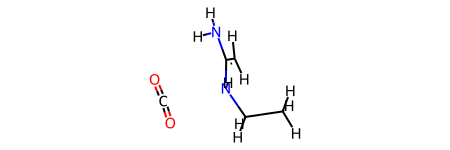

In [5]:
mol['conformers'][0]['rd_mol']

In [6]:
summary[smiles]

{'charge': 0,
 'ensembleenergy': 0.395,
 'ensembleentropy': 8.784,
 'ensemblefreeenergy': -2.619,
 'lowestenergy': -29.79082,
 'pickle_path': 'qm9/CCNC(=[NH2])[CH2].C(=O)=O.pickle',
 'poplowestpct': 21.057,
 'temperature': 298.15,
 'totalconfs': 1330,
 'uniqueconfs': 985}

In [7]:
def get_coords(mol, device = device, requires_grad = True):
    coords = []
    for i in range(len(mol['conformers'])):
        x = mol['conformers'][i]['rd_mol'].GetConformer().GetPositions()
        coords.append(x)
    coords = torch.Tensor(coords).to(device).requires_grad_(requires_grad)
    return coords

def get_atom_ids(mol, device = device):
    atoms = np.array([atom.GetSymbol() for atom in mol['conformers'][0]['rd_mol'].GetAtoms()])
    atom_ids = [getattr(periodictable, symbol).number for symbol in atoms]
    atom_ids = torch.Tensor(atom_ids).to(device).long().unsqueeze(0)
    return atom_ids


def interatomic_dist(x):
    # Compute the pairwise interatomic distances
    # removes duplicates and diagonal
    distances = x[:, None, :, :] - x[:, :, None, :]
    distances = distances[
        :,
        torch.triu(torch.ones((x.shape[1], x.shape[1])), diagonal=1)
        == 1,
    ]
    dist = torch.linalg.norm(distances, dim=-1)
    return dist

coords = get_coords(mol)
atom_ids = get_atom_ids(mol)
print(coords.shape, atom_ids)


torch.Size([985, 19, 3]) tensor([[6, 1, 1, 1, 6, 7, 6, 6, 1, 1, 7, 1, 1, 1, 1, 1, 6, 8, 8]],
       device='cuda:0')


/tmp/ipykernel_298727/445202615.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  coords = torch.Tensor(coords).to(device).requires_grad_(requires_grad)


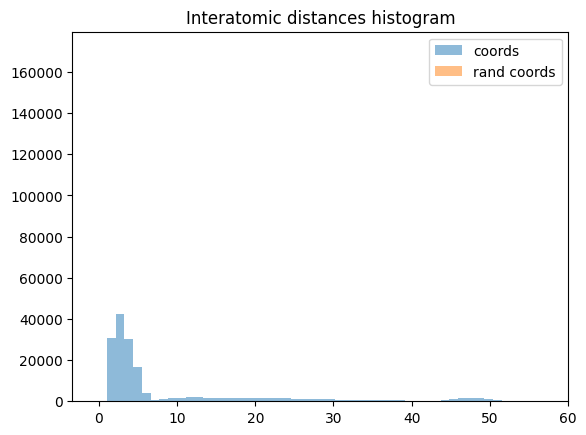

In [8]:
import matplotlib.pyplot as plt
dists = interatomic_dist(coords).detach().cpu().numpy()
plt.hist(dists.flatten(), bins=50, label = 'coords', alpha = 0.5)
n_rand = 1000
rand_coords = 0*torch.rand(n_rand,coords.shape[1],coords.shape[2]).to(coords.device)
rand_dists = interatomic_dist(rand_coords).detach().cpu().numpy()
plt.hist(rand_dists.flatten(), bins=50, label = 'rand coords', alpha = 0.5)
plt.legend()
plt.title('Interatomic distances histogram')
plt.show()

For torchANI, energies are in Hartree. but in the GEOM dataset, they are in  Kcal / mol, and 1Kcal / mol = 627.509 Hartree.


/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/site-packages/torchani/resources/


/tmp/ipykernel_298727/1582527517.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x for x in dict_data.keys() ])


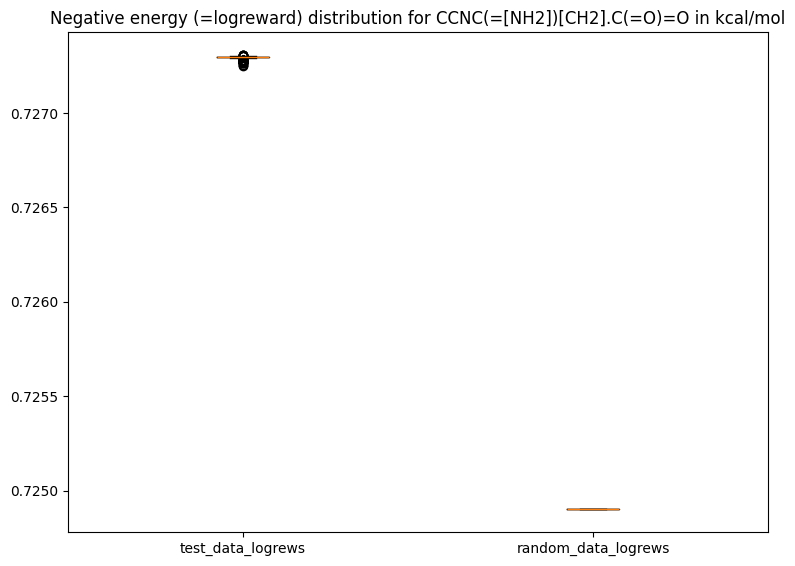

In [9]:
model = torchani.models.ANI2x(periodic_table_index=True).to(device)
test_data_logrews = - model((atom_ids.repeat(len(coords),1), coords)).energies / 627.509 
random_data_logrews = - model((atom_ids.repeat(n_rand,1), rand_coords )).energies / 627.509
dict_data = {'test_data_logrews': test_data_logrews.detach().cpu() , 'random_data_logrews':  random_data_logrews.detach().cpu()}
data = [x for x in dict_data.values()]
fig = plt.figure(figsize =(7, 5)) 
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels([x for x in dict_data.keys() ])
ax.set_title(f'Negative energy (=logreward) distribution for {smiles} in kcal/mol')
# Creating plot
bp = ax.boxplot(data)

# show plot
plt.show()


that's weird. Let's compare visually a batch of ground truth conformations and a batch of random conformations as a sanity check:

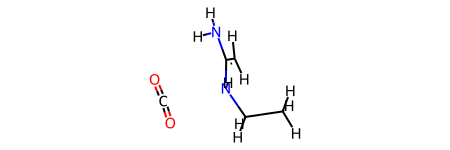

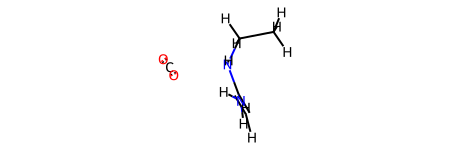

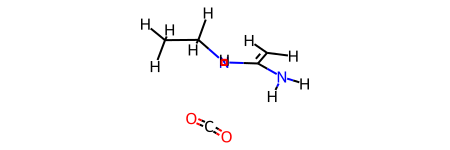

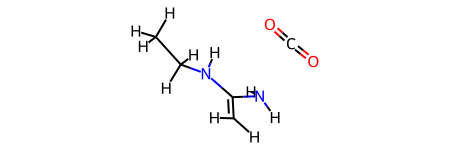

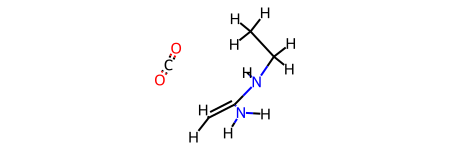

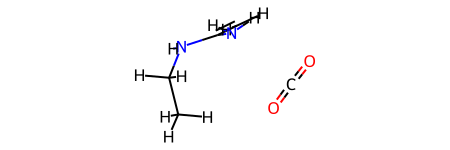

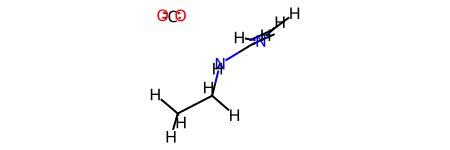

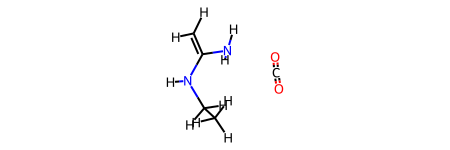

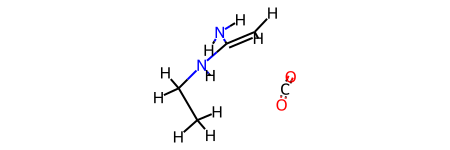

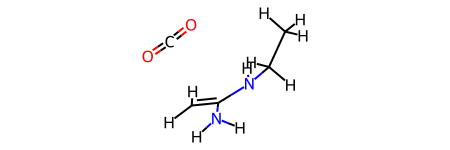

In [10]:
for i in range(10):
    display(mol['conformers'][i]['rd_mol'])


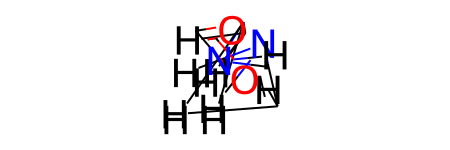

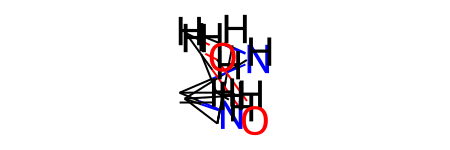

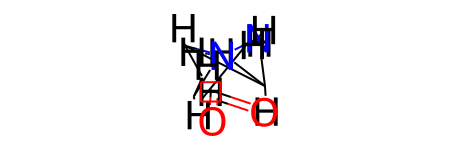

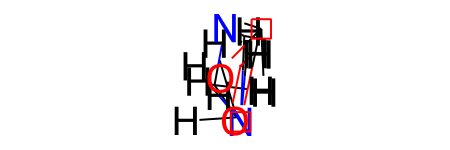

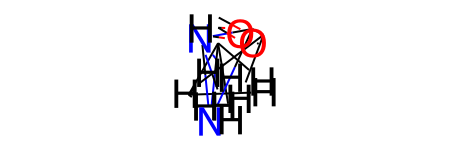

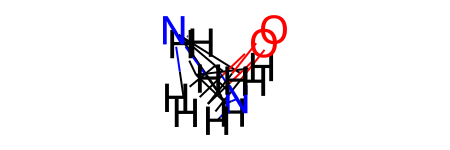

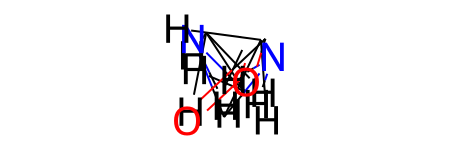

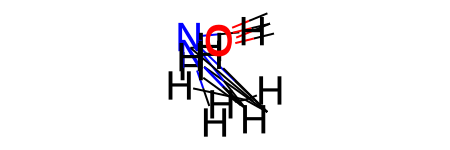

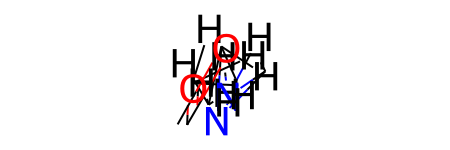

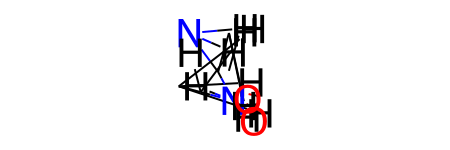

In [11]:
for i in range(10):
    conformer = mol['conformers'][i]['rd_mol'].GetConformer()
    #Set atom positions to the random positions from rand_coords
    for num_atom in range(conformer.GetNumAtoms()):
        #set atom position
        x,y,z = rand_coords[i][num_atom].double().cpu().numpy()
        conformer.SetAtomPosition(num_atom, Chem.rdGeometry.Point3D(x,y,z))
    display(mol['conformers'][i]['rd_mol'])


In [12]:
from dem.energies.tblite_energy import *

n_particles, n_dims = coords.shape[1], coords.shape[2]
energy_function = TBLiteEnergy(dimensionality = n_particles*n_dims, n_particles = n_particles, is_molecule=True, data_path =None,   data_path_train=None, data_path_val=None, T=0.1, device= device)
energy_function.atom_ids = atom_ids[0].cpu().numpy()

In [19]:
atom_ids, coords[0], rand_coords[0]

(tensor([[6, 1, 1, 1, 6, 7, 6, 6, 1, 1, 7, 1, 1, 1, 1, 1, 6, 8, 8]],
        device='cuda:0'),
 tensor([[ 2.8230, -1.0425,  0.3545],
         [ 3.0825, -0.8137,  1.3865],
         [ 3.3647, -1.9335,  0.0490],
         [ 3.1321, -0.2094, -0.2718],
         [ 1.3171, -1.2668,  0.2201],
         [ 0.5206, -0.1133,  0.5839],
         [ 0.5356,  1.0413, -0.2049],
         [ 0.8785,  1.0973, -1.4930],
         [ 1.2672,  0.2555, -2.0295],
         [ 0.7838,  2.0169, -2.0401],
         [ 0.1288,  2.1734,  0.5114],
         [-0.1028,  2.9512, -0.0897],
         [-0.6124,  1.9884,  1.1741],
         [ 0.6115,  0.1184,  1.5660],
         [ 1.0042, -2.0891,  0.8706],
         [ 1.0651, -1.5393, -0.8061],
         [-2.0058, -0.6204, -0.0338],
         [-1.7266, -1.5114, -0.6940],
         [-2.3622,  0.2548,  0.6158]], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor([[0.6898, 0.8639, 0.4106],
         [0.1462, 0.7921, 0.6802],
         [0.3180, 0.3927, 0.2877],
         [0.4146, 0.4814

In [20]:
test_data_logrews =   energy_function(coords[:2])


------------------------------------------------------------
  cycle        total energy    energy error   density error
------------------------------------------------------------


      1      1.623940767141   0.0000000E+00   0.0000000E+00
------------------------------------------------------------

logrew -1000000.0
------------------------------------------------------------
  cycle        total energy    energy error   density error
------------------------------------------------------------
      1      9932.621852752   9.9310049E+03   2.6225362E+00
      2      8701.383396992  -1.2312385E+03   4.0895310E+00
      3      8678.809024145  -2.2574373E+01   3.5574677E+00
      4      8910.854907678   2.3204588E+02   3.5658666E+00
      5      8860.868949911  -4.9985958E+01   3.6956703E+00
      6      8585.753020863  -2.7511593E+02   3.3851647E+00
      7      8576.758026025  -8.9949948E+00   2.9772631E+00
      8      9004.169828333   4.2741180E+02   2.9346493E+00
      9      8724.397208643  -2.7977262E+02   2.8113362E+00
     10      8438.731803457  -2.8566541E+02   2.1041493E+00
     11      8325.188497271  -1.1354331E+02   2.0267227E+00
     12      8209.

In [15]:
random_data_logrews =   energy_function(rand_coords[:5])

------------------------------------------------------------
  cycle        total energy    energy error   density error
------------------------------------------------------------
      1      1832.336329268   0.0000000E+00   6.0005249E+01
------------------------------------------------------------

logrew -1000000.0
------------------------------------------------------------
  cycle        total energy    energy error   density error
------------------------------------------------------------
      1      1124.227693060   0.0000000E+00   6.0005249E+01
------------------------------------------------------------

logrew -1000000.0
------------------------------------------------------------
  cycle        total energy    energy error   density error
------------------------------------------------------------
      1      1865.226671495   0.0000000E+00   6.0005249E+01
------------------------------------------------------------

logrew -1000000.0
----------------------------------

In [ ]:
import matplotlib.pyplot as plt

dict_data = {'test_data_logrews': test_data_logrews.detach().cpu() - 1e3 , 'random_data_logrews':  random_data_logrews.detach().cpu() - 1e3}
data = [x for x in dict_data.values()]
print(data[0].max(), data[0].min(), data[1].max(), data[1].min())
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels([x for x in dict_data.keys() ])
ax.set_title('log-reward distribution')
# Creating plot
bp = ax.boxplot(data)
ax.set_ylim([-100, 200])

# show plot
plt.show()

#TODO : explore the diversity of the conformations. It is weird that all test datapoints have the same reward ! 

# Dummy Energy

In [1]:
from dem.energies.dummy_energy import DummyEnergy
import numpy as np
import pickle
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
energy_function = DummyEnergy(dimensionality = 3*4, n_particles = 4, is_molecule=True, data_path =None,   data_path_train=None, data_path_val=None, T=0.1, device= device)

Data path for validation data is not provided
Data path for validation data is not provided


In [11]:
coords = torch.Tensor([[0,0,0], [1,0,0], [1,1,0],[0,1,0]])*0.01

In [12]:
energy_function(coords)

tensor(-12.1801, device='cuda:0')